In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy as sc
from scipy.sparse import diags, lil_matrix
#import numpy as np
import scipy.sparse as sp

from scipy.sparse.linalg import inv, spsolve
from functools import lru_cache


In [10]:
def unitcell(n,w,d,t,e):

    base = (w + 1j*d -e)*np.ones(n, dtype=np.complex64)
    hoppings = t * np.ones(n-1,dtype=np.complex64)

    unit = diags([base,hoppings,hoppings],[0,-1,1],format='lil')

    return unit.tocsr()

In [60]:
def hopping_znr(n,t):
    dim1 = np.arange(0,n-1,4)
    dim2 = np.arange(3,n,4)
    base = lil_matrix((n, n))

    base[dim1,dim1+1] = t
    base[dim2,dim2-1] = t

    return base.tocsr()

In [61]:
ho = hopping_znr(7,1).T.toarray()
ho

array([[0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [62]:


def leads(n, w, d, t, e,return_count=False):
    unit = inv(unitcell(n, w, d, t, e).tocsc())  # already CSC
    hopp = hopping_znr(n, t).tocsc()

    g = unit.copy().tocsc()
    G = unit.copy().tocsc()
    iden = sp.identity(n, dtype=complex, format="csc")
    g_hopp = g @ hopp.T

    diff = np.inf
    count = 0
    while diff > 1e-6:
        A = (iden - g_hopp @ G @ hopp).tocsc()
        G_new = sp.csc_matrix(spsolve(A, g))  # b is CSC
        diff = np.max(np.abs((G_new - G).data)) if G_new.nnz else 0.0
        G = G_new
        count +=1

    #print(count)

    return (G, count) if return_count else G

In [12]:
from tqdm import tqdm
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt

In [124]:
dos_leads = []

In [125]:
with tqdm(np.arange(0, 2, 0.01), desc="w sweep") as pbar:
    for w in pbar:
        G, count = leads(6, w, 0.001, 1, 0, return_count=True)  # return_count option explained below
        dos_leads.append(G)
        pbar.set_postfix(iterations=count)



w sweep: 100%|██████████| 200/200 [06:47<00:00,  2.04s/it, iterations=5583]


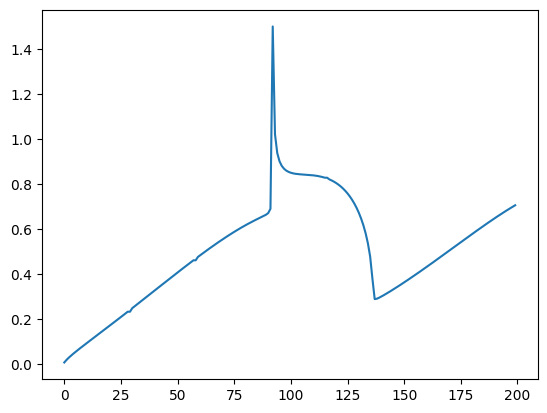

In [126]:
dos_1 = [] 

for w in np.arange(0,2,0.01):
    d1 = dos_leads[int(w*100)]
    dos_1.append(-np.imag(d1[2,2]))



plt.plot(dos_1)
#plt.ylim(0,10)

In [136]:
for l in range(5,30,1):
    dir_path = os.path.expanduser(f'~/Desktop/backup/zgnr/size_{l}')
    os.makedirs(dir_path, exist_ok=True)

#    dos_lead = []
    with tqdm(np.arange(0, 3, 0.01), desc="w sweep") as pbar:
        for w in pbar:
            G, count = leads(l, w, 0.0001, 1, 0, return_count=True)  # return_count option explained below
#            dos_lead.append(G.toarray())
            pbar.set_postfix(iterations=count)


            fn = os.path.join(dir_path, f'leads_{l}_w_{w:.2f}.csv')

    
            np.savetxt(fn, G.toarray(), delimiter=',')

    

w sweep:   1%|          | 3/300 [00:24<40:03,  8.09s/it, iterations=14179]


KeyboardInterrupt: 

In [70]:
def import_leads(n):
    dos_lead = []
    dir_path = os.path.expanduser(f'~/Desktop/backup/zgnr/size_{n}')
    for w in np.arange(0,3,0.01):
        fn = os.path.join(dir_path, f'leads_{n}_w_{w:.2f}.csv')
        data = np.loadtxt(fn, delimiter=',',dtype=np.complex64)
        dos_lead.append(data)

    return dos_lead


In [127]:
lead_6 = dos_leads

In [128]:
lead_6[0].toarray()

array([[ 0.00000000e+00-6.66275900e+01j,  9.33372410e-01+0.00000000e+00j,
         0.00000000e+00+3.36418777e-01j, -6.15282310e+00+0.00000000e+00j,
         0.00000000e+00-3.30265954e-01j,  6.15249283e+00+0.00000000e+00j],
       [ 9.33372410e-01+0.00000000e+00j,  0.00000000e+00-9.33372410e-04j,
         3.36418777e-04+0.00000000e+00j,  0.00000000e+00+6.15282310e-03j,
        -3.30265954e-04+0.00000000e+00j,  0.00000000e+00-6.15249283e-03j],
       [ 0.00000000e+00+3.36418777e-01j,  3.36418777e-04+0.00000000e+00j,
         0.00000000e+00-7.08586524e-03j,  9.33042144e-01+0.00000000e+00j,
         0.00000000e+00+6.15282310e-03j, -9.33035991e-01+0.00000000e+00j],
       [-6.15282310e+00+0.00000000e+00j,  0.00000000e+00+6.15282310e-03j,
         9.33042144e-01+0.00000000e+00j,  0.00000000e+00-3.36485399e-01j,
         6.66213705e-02+0.00000000e+00j,  0.00000000e+00+3.36418777e-01j],
       [ 0.00000000e+00-3.30265954e-01j, -3.30265954e-04+0.00000000e+00j,
         0.00000000e+00+6.15282310

In [108]:
def device(w,d,t,e):
    ene = int(w *100)
    size = 6
    left = lead_5[ene]
    right = lead_5[ene]

    hopp = hopping_znr(6,t)

    iden = np.eye(size)

    cl_1 = iden - left @ hopp @ right @ hopp.T
    il_l = np.linalg.solve(cl_1, left) 

    cr_1 = iden - right @ hopp.T @ left @ hopp
    il_r = np.linalg.solve(cr_1, right) 


    return il_l, il_r 


(0.0, 5.0)

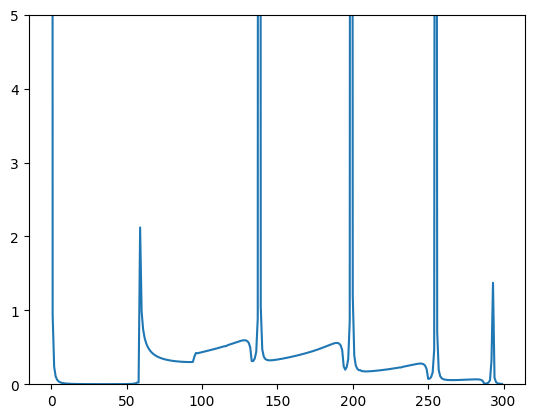

In [87]:
plt.plot(dos_il)
plt.ylim(0,5)

In [115]:
lead_5[0].toarray()

array([[ 0.        -4.39235806e+02j,  0.56076419+0.00000000e+00j,
         0.        +1.09623266e+02j, -0.36276403+0.00000000e+00j,
         0.        -1.09622903e+02j,  0.25314113+0.00000000e+00j,
         0.        +7.16493256e+01j, -0.14599196+0.00000000e+00j,
         0.        -7.16491796e+01j,  0.07434278+0.00000000e+00j,
         0.        +7.43427756e+01j],
       [ 0.56076419+0.00000000e+00j,  0.        -5.60764194e-04j,
         0.10962327+0.00000000e+00j,  0.        +3.62764032e-04j,
        -0.1096229 +0.00000000e+00j,  0.        -2.53141129e-04j,
         0.07164933+0.00000000e+00j,  0.        +1.45991955e-04j,
        -0.07164918+0.00000000e+00j,  0.        -7.43427756e-05j,
         0.07434278+0.00000000e+00j],
       [ 0.        +1.09623266e+02j,  0.10962327+0.00000000e+00j,
         0.        -7.16501395e+01j,  0.45114129+0.00000000e+00j,
         0.        +7.16496884e+01j, -0.3794916 +0.00000000e+00j,
         0.        -7.43431031e+01j,  0.18149195+0.00000000e+00j,


In [131]:
def device(w, d, t, e):
    ene = int(w * 100)
    m = 6

    SL = dos_leads[ene].toarray()     # left lead surface Green's function
    SR = dos_leads[ene].toarray()     # right lead
    T  = hopping_znr(m, t)

    I = np.eye(m, dtype=complex)
    Td = T.conj().T

    IL = np.linalg.solve(I - SL @ Td @ SR @ Td, SL)
    IR = np.linalg.solve(I - SR @ Td @ SL @ Td, SR)

    gdd = IL - IL.conj().T
    grr = IR - IR.conj().T

    Gnonlocal = SR @ Td @ IL
    GNON = Gnonlocal - Gnonlocal.conj().T

    term1 = gdd @ T @ grr @ Td
    term2 = T @ GNON @ Td @ GNON

    tr1 = np.abs(np.trace(term1 - term2))

    return tr1


In [132]:
device(0,0.001,1,0)

np.float64(2.1615147796433583)

In [134]:
dos_il = []
dos_ir = []
for w in np.arange(0,2,0.01):

    il = device(w,0.001,1,0) 

    dos_il.append(il)


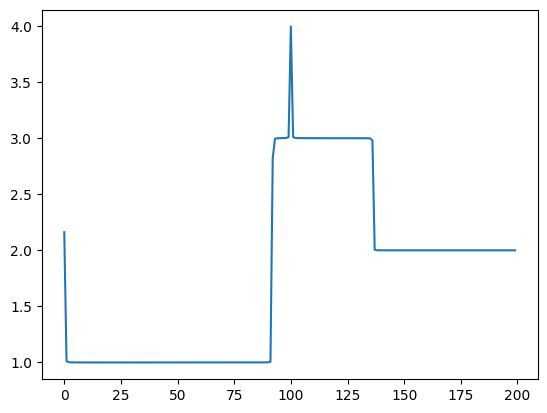

In [135]:
plt.plot(dos_il)
